# Machine learning - Face Recognition project - Created by Max Feldman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn import datasets, cluster
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition, datasets

# to plot the final table
import pandas as pd

#To read our data from memory
import os 
from PIL import Image

# just to make the code more cleaner
import warnings
warnings.filterwarnings("ignore")

# Before starting, my main goal was to try to use the "ORL faces - data set" and to figure out whether its possible to create a good model that can make correct face predictions#

### In this project i will try to recognize the right person (40 people in total) , people who wear glasses and finally i will try to find out if the person is a male or female. ##

#### First of all, i will use Pillow library to import the dataset into the project #### 

In [2]:
def read_images():
    path = 'att_faces\orl_faces'
    X = []
    y = []
    for i in range(40):
        for j in range(10):
            img = Image.open(os.path.join(path,'s'+str(i+1), str(j+1)+'.pgm'))
            X.append(np.asarray(img, dtype=np.uint8).flatten())
            y.append(i)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


In [3]:
data,data_ids = read_images()

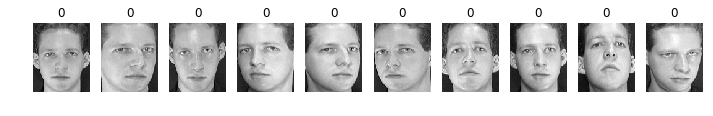

In [4]:
plt.figure(figsize=(12,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(data[i].reshape(112, 92), cmap='binary_r',label="dasd")
    plt.title(data_ids[i])
    plt.axis('off')   
plt.show()

#### Each person in this data set have 10 different samples of his face. the person represented by a numerical "id-number"

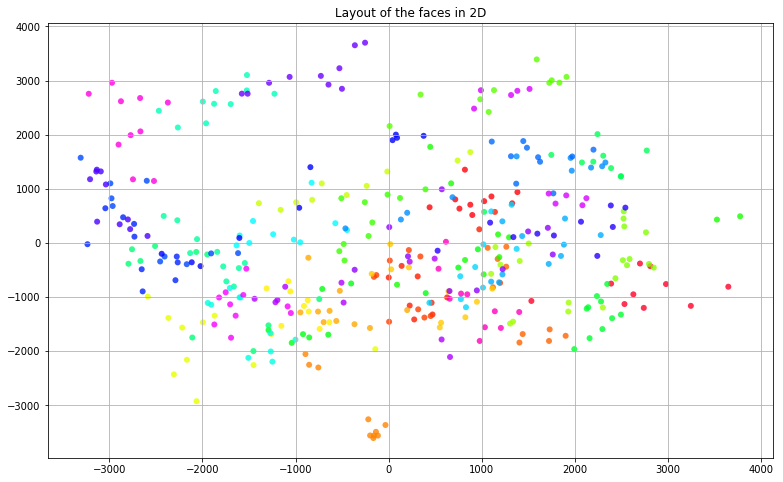

In [5]:

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(data)
plt.figure(figsize=(13,8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=data_ids, edgecolor='none', alpha=0.8,cmap='gist_rainbow')
plt.title("Layout of the faces in 2D")
plt.grid()
plt.show()

#### Before starting, i would like to plot my data in 2-D using PCA dimmenstion reduction

#### Before proceeding to create our models, lets try to find out if we can discover some new information about our data by trying to cluster our data into different groups"####

Our Data represented by 2 clusters.


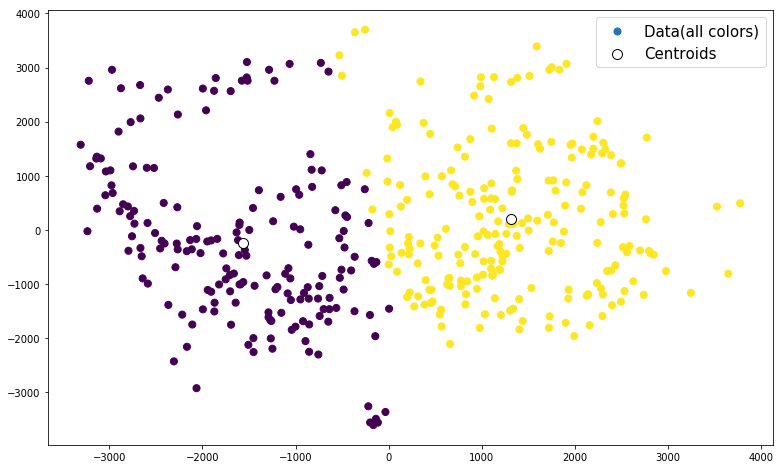

Our Data represented by 3 clusters.


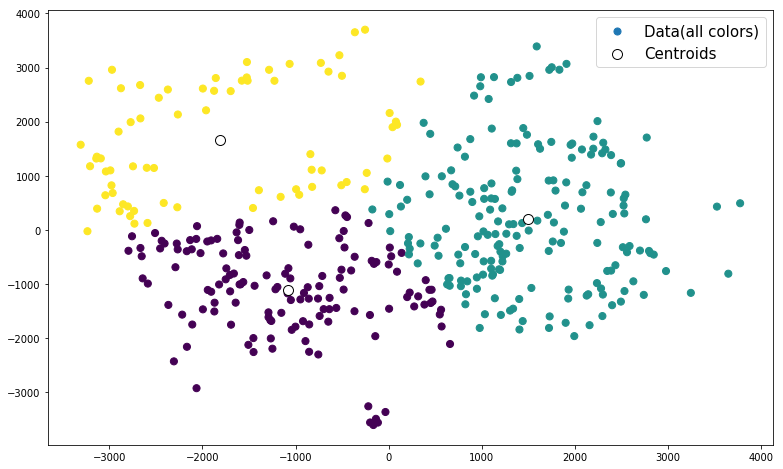

Our Data represented by 4 clusters.


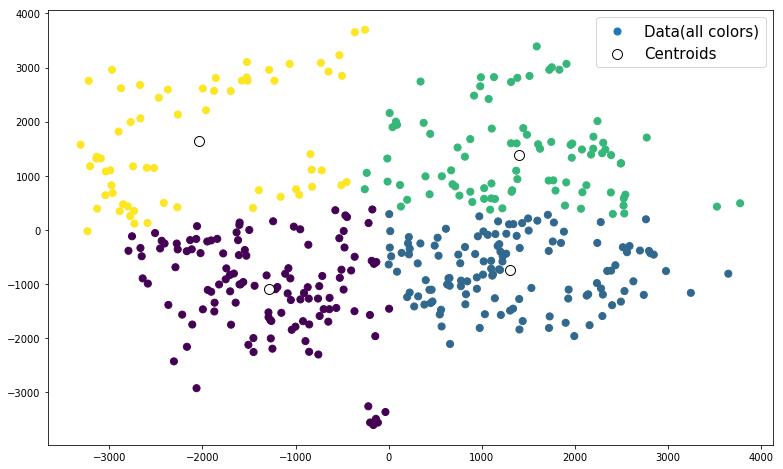

In [6]:
y_of_kmeans = []

def cluster_the_data(num_of_clusters):
    for i in range(2,num_of_clusters):
        kmeans = KMeans(i)
        kmeans.fit(projected)
        y_kmeans = kmeans.predict(projected)
        print("Our Data represented by",i,"clusters.")
        plt.figure(figsize=(13,8))
        centroids = kmeans.cluster_centers_
        plt.scatter(projected[:, 0], projected[:, 1], c=y_kmeans, s=50, cmap='viridis')
        plt.scatter(centroids[:, 0], centroids[:, 1], c='white',marker='o',edgecolors='black', s=100, alpha=1);
        plt.legend(['Data(all colors)','Centroids'],prop={'size': 15})
        plt.show()
        y_of_kmeans.append(y_kmeans)
    
cluster_the_data(5)

In [7]:
def find_the_best_of_k_index(array_of_costs):
    best_k_index = 0
    cost_old = array_of_costs[0]
    for i in range(1,len(array_of_costs)):
        new_cost = array_of_costs[i]
        if(cost_old *(0.85) > new_cost): # If the new price is 0.85% lower than the previous price then we will update the price to be the new price and increase the number of our clusters by 1
            old = cost_old
            cost_old = new_cost
            best_k_index = i
        else:
            break

    return best_k_index,old

#### We can continue and cluster our data on and on however we want to find the appropriate number (k) of clusters in a dataset , untill we can see that adding more clusters not contributing that much as the first few clusters, in order to do it i will use the elbow-method to find the right number of clusters####

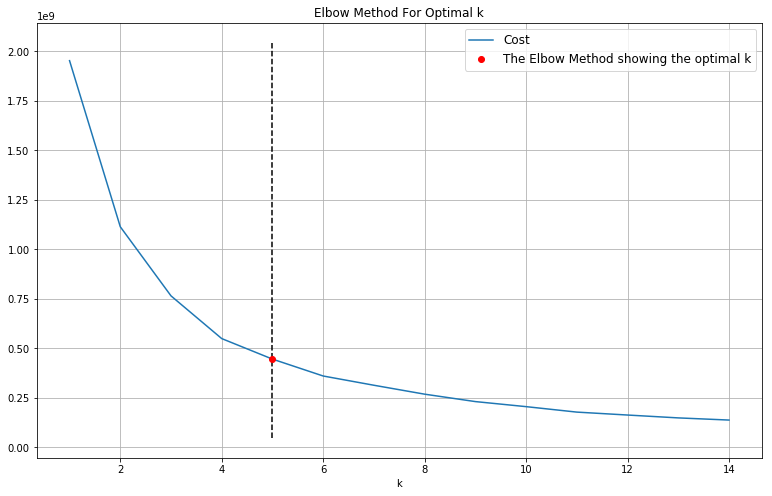

In [8]:
sum_of_cost = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(projected)
    sum_of_cost.append(km.inertia_)
    
best_k,best_k_cost = find_the_best_of_k_index(sum_of_cost)


plt.figure(figsize=(13,8))
plt.plot(K,sum_of_cost)
plt.plot(best_k,best_k_cost,'ro')
plt.vlines(best_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed') # to show the elbow dotted line
plt.xlabel('k')
plt.title('Elbow Method For Optimal k')
plt.legend(['Cost','The Elbow Method showing the optimal k'],prop={'size': 12})
plt.grid()
plt.show()

#### Before implementing the models we must take to consideration using “dimensionality reduction” as it can be a very useful step for visualising and processing high-dimensional datasets, while still retaining as much of the variance in the dataset as possible. In order to do it we will use PCA algorithm. ####

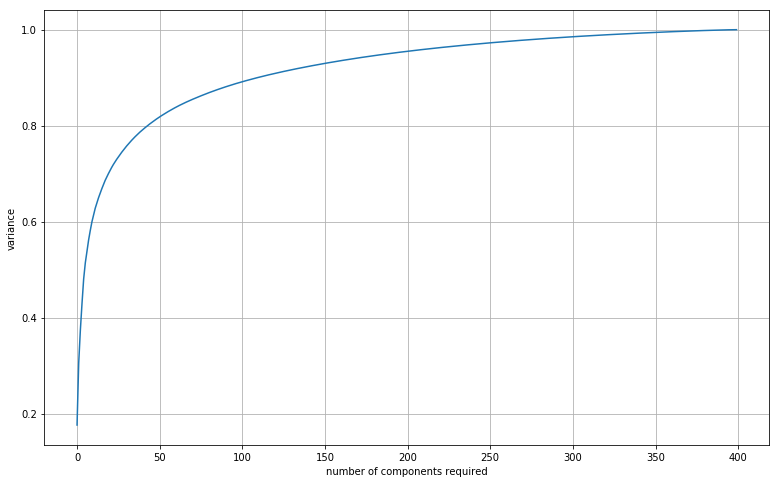

In [9]:
#so how much data are we not using? 
pca = PCA(svd_solver='randomized',n_components=400) #randomized is better for large dataset
pca.fit(data)
plt.figure(figsize=(13,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components required')
plt.ylabel('variance');

#### We can see that if we try to meassure what is the best variance ratio to use in our PCA ,150 components will require to describe 0.9 of the variance , while for 1.0 of the variance we will need 400 components ####

we can look on several of our first 'eigenvectors'


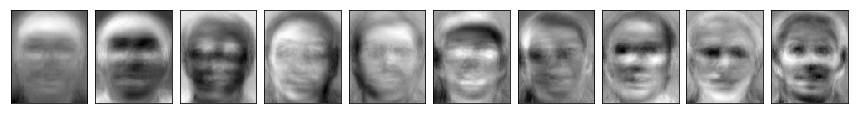

In [10]:
print("we can look on several of our first 'eigenvectors'")
fig, axes = plt.subplots(1, 10, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]}, # just to avoid the x,y lines
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(112, 92), cmap='binary_r')

    

#### We run PCA and find principal components (eigenvectors) which represent "salient" properties of the faces. These eigenvectors can be converted back into a bitmap, which can be visualized and are called "eigenfaces".####

In [11]:
pca = PCA(150).fit(data)  # taking only 150 dimenssions
components = pca.transform(data)
projected = pca.inverse_transform(components)

Real Amount of dimesions


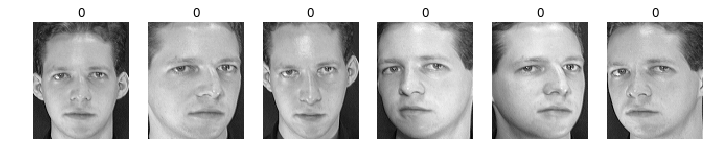

only 150 dimensions


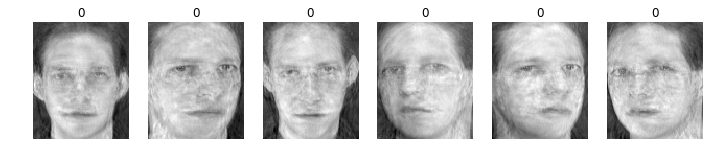

In [12]:
# Plot the results
plt.figure(figsize=(12,10))
print("Real Amount of dimesions")
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(data[i].reshape(112, 92), cmap='binary_r')
    plt.title(data_ids[i])
    plt.axis('off')
    
plt.ylabel="full dimension"
plt.show() 

print("only 150 dimensions")
plt.figure(figsize=(12,10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(projected[i].reshape(112, 92), cmap='binary_r',label="dasd")
    plt.title(data_ids[i])
    plt.axis('off')   
plt.show() 

#### Clearly we can see that even when we took only 150 dimensions most of the important details are still preserved ####

In [13]:
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(projected, data_ids, test_size = 0.2, random_state = 0,stratify=data_ids)


#### now lets try to split our data into train set and test set in a ratio of 80% train , 20% test with data reduced to 150 dimmensions ####

# SVM Model#

#### In the proccess of building the model i will set different hyperparameters to check how each parameter will effect my model score , i will also try to find the best (gamma - predictions ratio) to deminstrate how changing one setting can effect the amount of predictions ####

In [14]:
def create_svm_model(gamma_amount='auto'):
    svc = SVC(C=100,kernel='rbf', class_weight='balanced',gamma=gamma_amount)
    model = make_pipeline(pca, svc) # we use a pipeline here to connect both of the componnents together
    pred = model.fit(X_face_train,y_face_train)
    face_pred = model.predict(X_face_test)
    svm_score = model.score(X_face_test,y_face_test)
    
    return face_pred,svm_score

In [15]:
 def execute_svm_model(myRange=20):
    correct_path= []
    gamma_path = []
    gamma_amount = 0.00000001
    best_gamma=0.00000001
    best_pred = 0
    #print_sample_faces(X_face_test,face_pred,y_face_test)
    for i in range(myRange):
        face_pred,svm_score=create_svm_model(gamma_amount)
        correct_path.append((calc_errors(face_pred,y_face_test)))
        if(correct_path[i]>best_pred):
            best_pred = correct_path[i]
            best_gamma = gamma_amount    
        gamma_path.append((gamma_amount))    
        gamma_amount = gamma_amount*2
        if(gamma_amount>myRange*2):
            break
        if(i>myRange/2 and (correct_path[i]==correct_path[i-1]==correct_path[i-2])):
            break # just to check that we are not checking to many times for the correct Gamma if the predictions count not changing at all                                                           
        
        
    return correct_path,gamma_path,best_gamma,best_pred,face_pred
        


In [16]:
def calc_errors(face_pred,y_face_test):
    correct = 0
    incorrect = 0

    for i in range(80):
        if(face_pred[i] == y_face_test[i]):
            correct = correct +1
        else:
            incorrect = incorrect+1
    
    return correct
    

In [17]:
def print_sample_faces(X_face_test,face_pred,y_face_test):
    fig, ax = plt.subplots(4, 6)
    for i, axi in enumerate(ax.flat):
        axi.imshow(X_face_test[i].reshape(112, 92), cmap='binary_r')
        axi.set(xticks=[], yticks=[])
        axi.set_ylabel(face_pred[i])
        if(face_pred[i] == y_face_test[i]):
            axi.set_xlabel("TRUE",color='green')
        else:
            axi.set_xlabel("FALSE",color='red')
    plt.tight_layout()

#### In this section i will search for the best Gamma - C ratio using PCA reduced to 150 dimensions and RBF Kernel with GridSearchCV

In [18]:
def gridSearch(myKernel='rbf'):
    clf_ = SVC(kernel=myKernel)
    Cs = [1e-13,1e-10,0.0000001,0.000001,0.00001,0.0001,1,5,30]
    Gammas = [1e-16,1e-11,1e-10,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.000125]
    clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=2,
                 pre_dispatch='1*n_jobs',
                 n_jobs=1)

    clf.fit(X_face_train, y_face_train)

    scores = [x[1] for x in clf.grid_scores_]
    scores = np.array(scores).reshape(len(Cs), len(Gammas))
    cv_results = clf.cv_results_['mean_test_score'].reshape(len(Cs),len(Gammas))
    return clf,Cs,Gammas,scores,cv_results

In [19]:
def plot_grid_path(Cs,Gammas,scores):
    plt.figure(figsize=(13,8))
    for ind, i in enumerate(Cs):
        plt.plot(Gammas, scores[ind],'-o', label='C: ' + str(i))
    plt.legend()
    #plt.xlabel('C')
    #plt.ylabel('Gamma')
    plt.title('Model Score with Gamma and C combinations using GridSearchCV')
    plt.grid()
    plt.show()

def plot_grid_heatmap(Cs,Gammas,cv_results):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(cv_results, interpolation='nearest', cmap=plt.cm.hot)
    #plt.xlabel('C')
    #plt.ylabel('Gamma')
    plt.colorbar()
    plt.xticks(np.arange(len(Cs)), Cs)
    plt.yticks(np.arange(len(Gammas)), Gammas)
    plt.title('Grid Search HeatMap Score')
    plt.show()

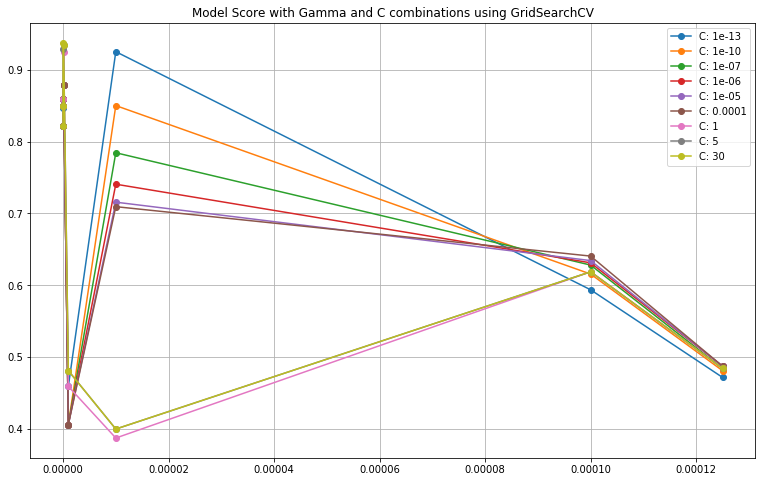

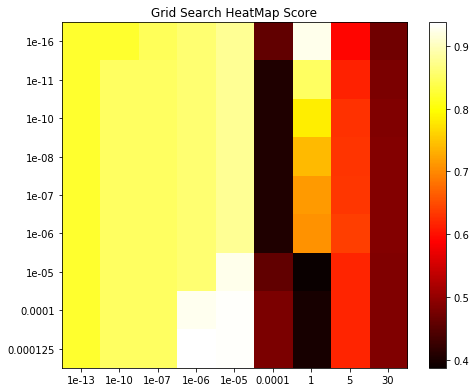

The best GridSearch HyperParameters Are:
{'C': 30, 'gamma': 1e-08}
With Score : 0.9375


In [20]:
clf,Cs,Gammas,scores,cv_results = gridSearch('rbf')
plot_grid_path(Cs,Gammas,scores)
plot_grid_heatmap(Cs,Gammas,cv_results)
print("The best GridSearch HyperParameters Are:")
print(clf.best_params_)
print("With Score :",clf.best_score_)

#### Now lets try to make the same search but this time with PCA reduced to only 50 dimensions

In [21]:
pca50 = PCA(50).fit(data)  # taking only 150 dimenssions
components = pca50.transform(data)
projected50 = pca50.inverse_transform(components)
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(projected50, data_ids, test_size = 0.2, random_state = 0,stratify=data_ids)

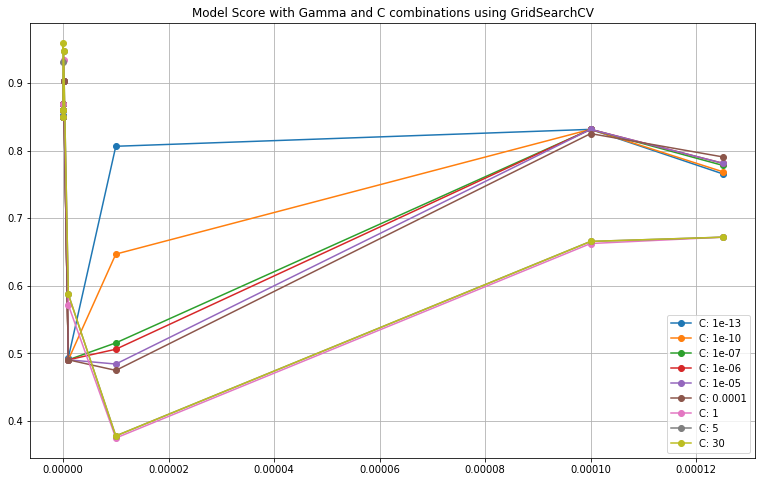

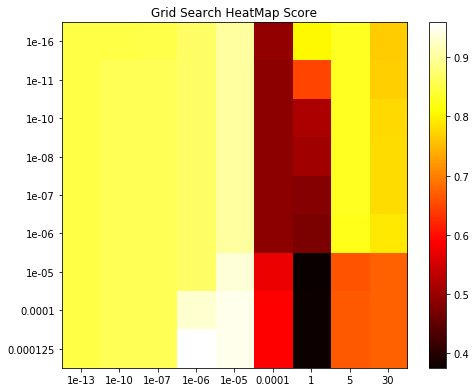

The best GridSearch HyperParameters Are:
{'C': 30, 'gamma': 1e-08}
With Score : 0.959375


In [22]:
clf,Cs,Gammas,scores,cv_results = gridSearch('rbf')
plot_grid_path(Cs,Gammas,scores)
plot_grid_heatmap(Cs,Gammas,cv_results)
print("The best GridSearch HyperParameters Are:")
print(clf.best_params_)
print("With Score :",clf.best_score_)

#### in order to understand how our hyperparameters chaning our prediction amount i will demonstrate the change with different Gamma values

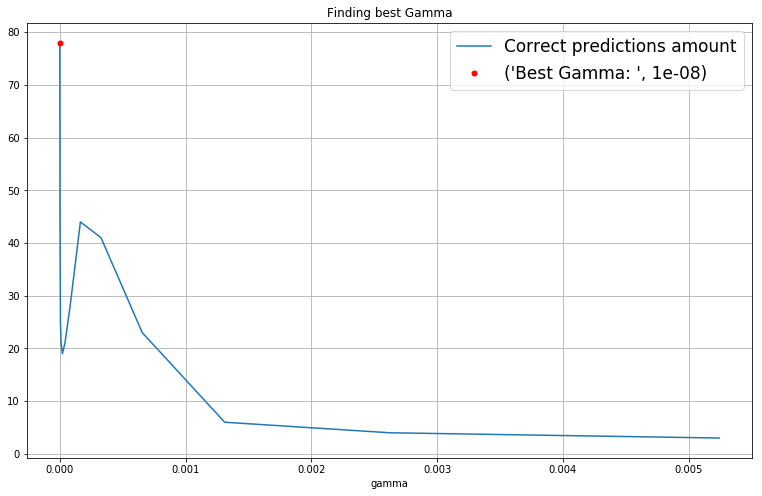

Best amount of CORRECT predictons is : 78  Best Gamma Amount is :  1e-08


In [23]:
final_pred = []
model_score= []
model_gamma= []

correct_path,gamma_path,best_gamma,best_pred,face_pred = execute_svm_model()
def print_gamma_path(correct_path,gamma_path):
    plt.figure(figsize=(13,8))
    plt.plot(gamma_path,correct_path)
    plt.grid()
    plt.xlabel('gamma')
    plt.plot(best_gamma,best_pred, "ro", markersize=5)
    #plt.ylabel('Correct predictions')
    plt.title('Finding best Gamma')
    plt.legend(['Correct predictions amount',("Best Gamma: ",best_gamma)],prop={'size': 17})
    plt.show()
final_pred.append(best_pred)
print_gamma_path(correct_path,gamma_path)
print("Best amount of CORRECT predictons is :",best_pred," Best Gamma Amount is : ",best_gamma)
   

Correct predictions are written in green,incorrect in red
Example of the 24 first faces of the test set:


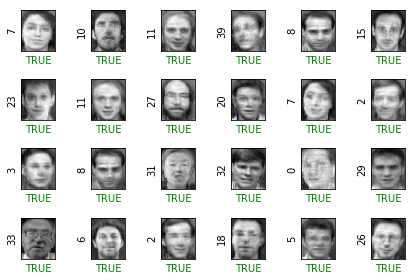

In [24]:
print("Correct predictions are written in green,incorrect in red")
print("Example of the 24 first faces of the test set:")
#finally taking the best  gamma
face_pred,svm_score = create_svm_model(best_gamma)
print_sample_faces(X_face_test,face_pred,y_face_test)
model_score.append(svm_score)
model_gamma.append(best_gamma)

In [25]:
print(classification_report(y_face_test,face_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         2
          4       1.00      1.00      1.00         2
          5       1.00      1.00      1.00         2
          6       1.00      1.00      1.00         2
          7       1.00      1.00      1.00         2
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         2
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         2
         14       1.00      1.00      1.00         2
         15       0.67      1.00      0.80         2
         16       1.00      1.00      1.00         2
         17       1.00      1.00      1.00   

#### As we can see, the model did quite well : 78 Correct predictions out of 80

In [26]:
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(projected, data_ids, test_size = 0.2, random_state = 0,stratify=data_ids)

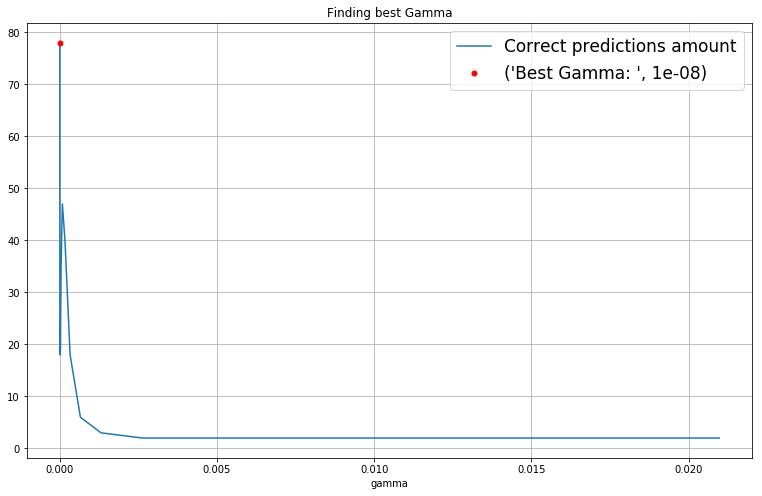

Best amount of CORRECT predictons is : 78  Best Gamma Amount is :  1e-08


In [27]:
correct_path,gamma_path,best_gamma,best_pred,face_pred = execute_svm_model(40)
def print_gamma_path(correct_path,gamma_path):
    plt.figure(figsize=(13,8))
    plt.plot(gamma_path,correct_path)
    plt.grid()
    plt.xlabel('gamma')
    plt.plot(best_gamma,best_pred, "ro", markersize=5)
    #plt.ylabel('Correct predictions')
    plt.title('Finding best Gamma')
    plt.legend(['Correct predictions amount',("Best Gamma: ",best_gamma)],prop={'size': 17})
    plt.show()
final_pred.append(best_pred)
print_gamma_path(correct_path,gamma_path)
print("Best amount of CORRECT predictons is :",best_pred," Best Gamma Amount is : ",best_gamma)

# Logistic Regression Model#

In [28]:
logistic = LogisticRegression()
model = make_pipeline(pca, logistic) # we use a pipeline here to connect both of the componnents together
pred = model.fit(X_face_train,y_face_train)
face_pred = model.predict(X_face_test)
logistic_score = model.score(X_face_test,y_face_test)
best_log_pred = calc_errors(face_pred,y_face_test)
best_pred = calc_errors(face_pred,y_face_test)

model_score.append(logistic_score)
final_pred.append(best_log_pred)

Correct predictions are written in green,incorrect in red
Example of the 24 first faces of the test set:
Best amount of CORRECT predictons is : 72


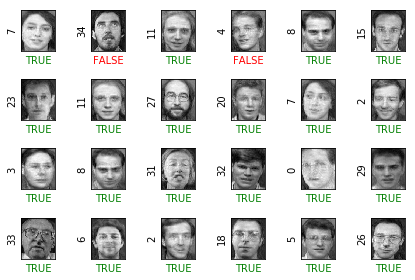

In [29]:
print("Correct predictions are written in green,incorrect in red")
print("Example of the 24 first faces of the test set:")
print_sample_faces(X_face_test,face_pred,y_face_test)
print("Best amount of CORRECT predictons is :",best_pred)

In [30]:
print(classification_report(y_face_test,face_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         2
          4       0.33      0.50      0.40         2
          5       1.00      1.00      1.00         2
          6       1.00      1.00      1.00         2
          7       1.00      1.00      1.00         2
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       0.00      0.00      0.00         2
         11       1.00      1.00      1.00         2
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         2
         14       1.00      1.00      1.00         2
         15       1.00      1.00      1.00         2
         16       1.00      1.00      1.00         2
         17       1.00      1.00      1.00   

#### The Logistic Regression model was a little bit worse then the previous SVM model - 72 correct predictions out of 80. but in total it's still a good ratio. ####

# Glasses# 
### now lets try to find pepole with glasses by creating our own data set and manually marking the pepole who wear glasses ###

after searching for this pepole we found out that these are the segments of the relavent data :
	10- 19, 30-32,37,-38,50,-59,63-64,
	69,120-121, 124-129,130-139,160-161,
	164-169,180-182,185-185,189-189,190-192,
	194-194,196-199,260-269,270-279,300-309,
	330-339,358-359,360-369.


In [31]:
glasses = [
(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
(330, 339), (358, 359), (360, 369)
]

def mark_with_criteria(criteria_list):
    criteria_target = []
    for i in range(len(criteria_list)):
        start , end = criteria_list[i]
        offset = (int(end) - int(start)) +1
        for j in range(offset):
            criteria_target.append(start)
            start = start+1
    return criteria_target       
glasses_target = mark_with_criteria(glasses)     
print("New X targets after manually generated: \n" )
print(glasses_target)

New X targets after manually generated: 

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 37, 38, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 69, 120, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 160, 161, 164, 165, 166, 167, 168, 169, 180, 181, 182, 185, 189, 190, 191, 192, 194, 196, 197, 198, 199, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369]


In [32]:
def create_y_targets(glasses_target):
    glasses_y = []
    for i in range(len(data)):
        if i in glasses_target:
            glasses_y.append(1)
        else:
            glasses_y.append(0)
    return glasses_y

glasses_y =create_y_targets(glasses_target)

                            

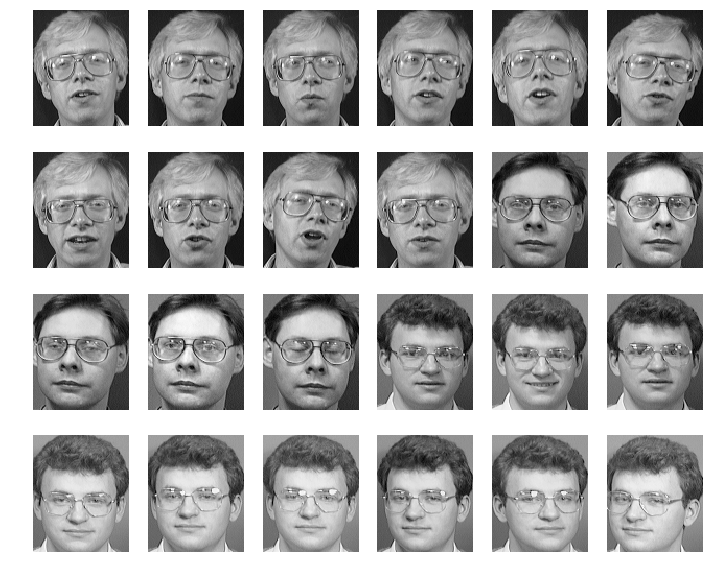

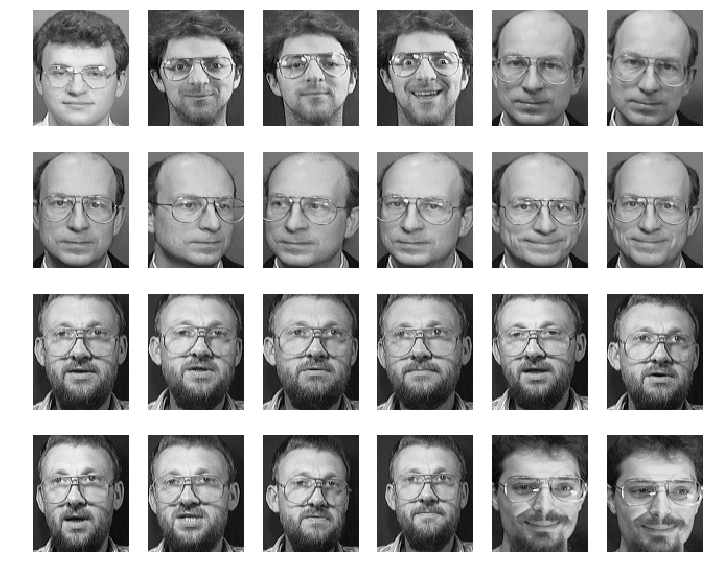

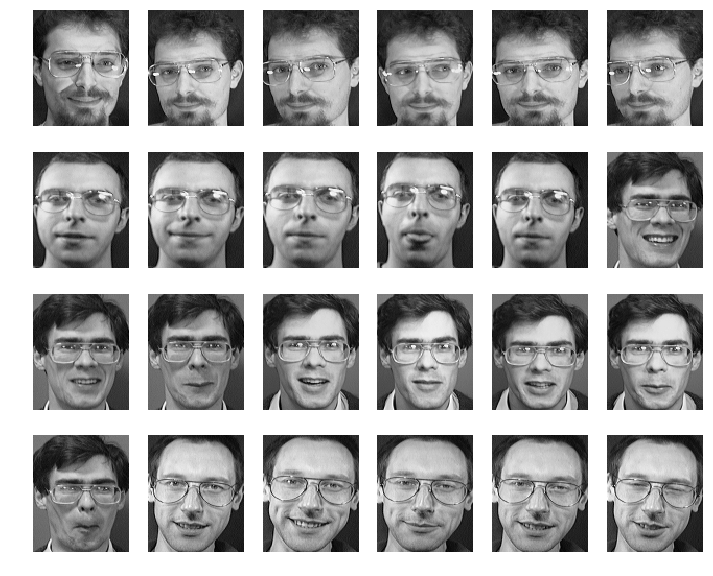

In [33]:
def print_samples_with_glasses():
    for j in range(3):
        plt.figure(figsize=(12,10))
        for i in range(24):
            plt.subplot(4, 6, i+1)
            plt.imshow(data[glasses_target[i+(24*j)]].reshape(112, 92), cmap='binary_r',label="dasd")
            plt.axis('off')   
        plt.show()
    
print_samples_with_glasses()    

#### as we can see,the all the collected samples are pepole with glasses

In [34]:
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(projected, glasses_y, test_size = 0.2, random_state = 0)


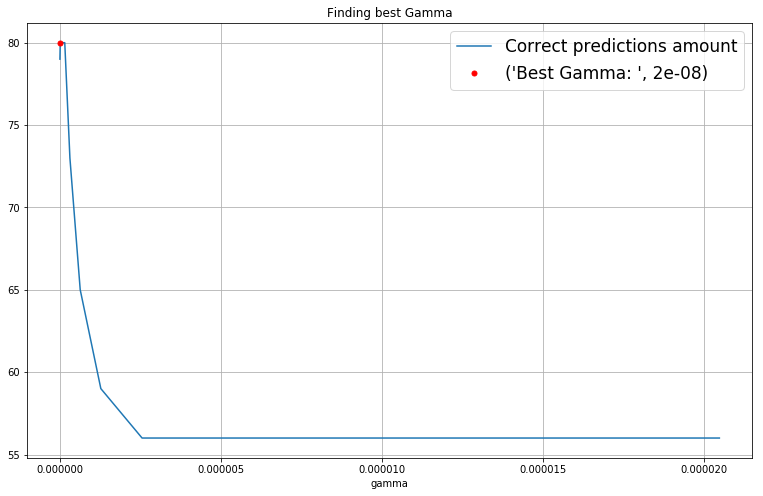

Best amount of CORRECT predictons is : 80  Best Gamma Amount is :  2e-08


In [35]:
correct_path,gamma_path,best_gamma,best_pred,face_pred = execute_svm_model()
print_gamma_path(correct_path,gamma_path)
print("Best amount of CORRECT predictons is :",best_pred," Best Gamma Amount is : ",best_gamma)

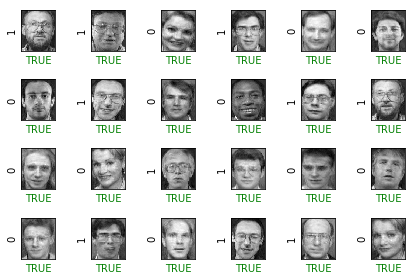

In [36]:
face_pred,svm_score =create_svm_model(best_gamma)
print_sample_faces(X_face_test,face_pred,y_face_test)
model_score.append(svm_score)
final_pred.append(best_pred)
model_gamma.append(best_gamma)

In [37]:
print(classification_report(y_face_test,face_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        56
          1       1.00      1.00      1.00        24

avg / total       1.00      1.00      1.00        80



# Gender##

### now lets try to find out if we can distinguish males from females, just like the previous model, i will try to manually generate the "y" values for the relevant samples ###

In [38]:
females = [
(70,79),(90,99),(310,319),(340,349)
]

females_target = mark_with_criteria(females)
print(females_target)

[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]


In [39]:
females_y = create_y_targets(females_target)

In [40]:
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(projected, females_y, test_size = 0.2, random_state = 0,stratify=females_y)

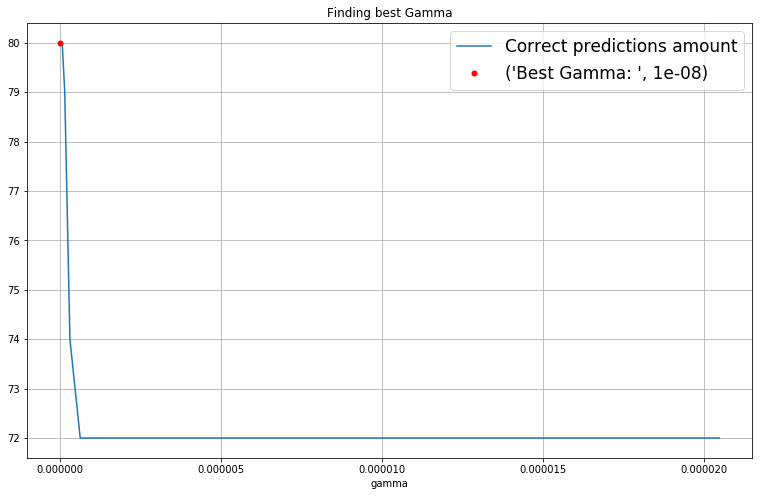

Best amount of CORRECT predictons is : 80  Best Gamma Amount is :  1e-08


In [41]:
correct_path,gamma_path,best_gamma,best_pred,face_pred = execute_svm_model()
print_gamma_path(correct_path,gamma_path)
print("Best amount of CORRECT predictons is :",best_pred," Best Gamma Amount is : ",best_gamma)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        72
          1       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        80



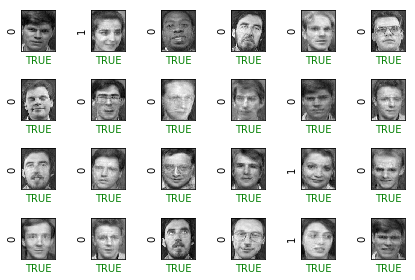

In [42]:
face_pred,svm_score =create_svm_model(best_gamma)
print_sample_faces(X_face_test,face_pred,y_face_test)
model_score.append(svm_score)
final_pred.append(best_pred)
model_gamma.append(best_gamma)
print(classification_report(y_face_test,face_pred))


### Finally lets look on the summary of our models

In [43]:
df = []
data = [['SVM-Faces','rbf',final_pred[0],80,model_score[0],model_gamma[0]],
        ['Logistic-Regression-Faces',None,final_pred[1],80,model_score[1],None],
        ['SVM-Glasses','rbf',final_pred[2],80,model_score[2],model_gamma[1]],
        ['SVM-Gender','rbf',final_pred[3],80,model_score[3],model_gamma[2]]]  

df = pd.DataFrame(data,columns=['Model name','Kernel','Correct Predictions','Total Samples','Model Score','Gamma'])
df.head()

,Model name,Kernel,Correct Predictions,Total Samples,Model Score,Gamma
0,SVM-Faces,rbf,78,80,0.975,1.000000e-08
1,Logistic-Regression-Faces,None,78,80,0.900,NaN
2,SVM-Glasses,rbf,72,80,1.000,2.000000e-08
3,SVM-Gender,rbf,80,80,1.000,1.000000e-08
